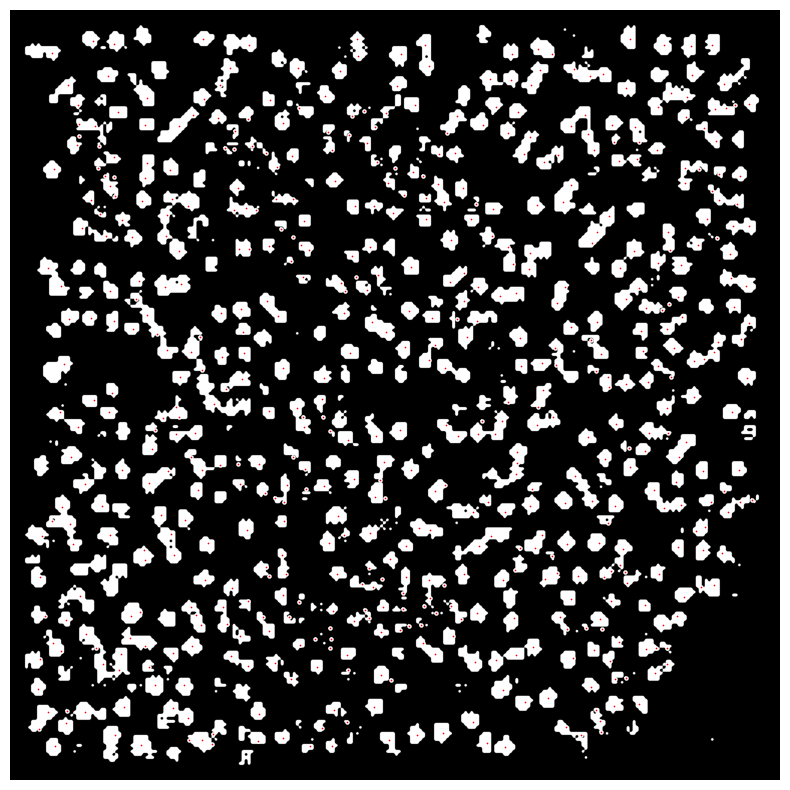

In [1]:
import cv2
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
import json


mask_path ='/root/autodl-tmp/checkpoint/SAM_Med2D_mona_mask1/results_CNN/10017/masks/Falcon_2012_06_12-14_33_35_0_mask.jpg'
# 读取mask图像（单通道）
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
# unique_values = np.unique(mask)
# print(unique_values)
mask = (mask>127).astype(np.uint8)

original_height , original_width =mask.shape

plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.axis("off")  # 隐藏坐标轴

with open('/root/autodl-tmp/datasets/test_dataset/10017/points2/Falcon_2012_06_12-14_33_35_0.json', 'r') as file:
    points = json.load(file)
    
# 计算缩放比例
scale_x = 1024 / original_width
scale_y = 1024 / original_height

# data是先x后y
restored_points = [(x / scale_x, y / scale_y) for x, y,_ in points]
# 标注点
x_coords = [point[0] for point in restored_points]
y_coords = [point[1] for point in restored_points]
plt.scatter(x_coords, y_coords, c='red', s=5, edgecolor='white')
plt.show()

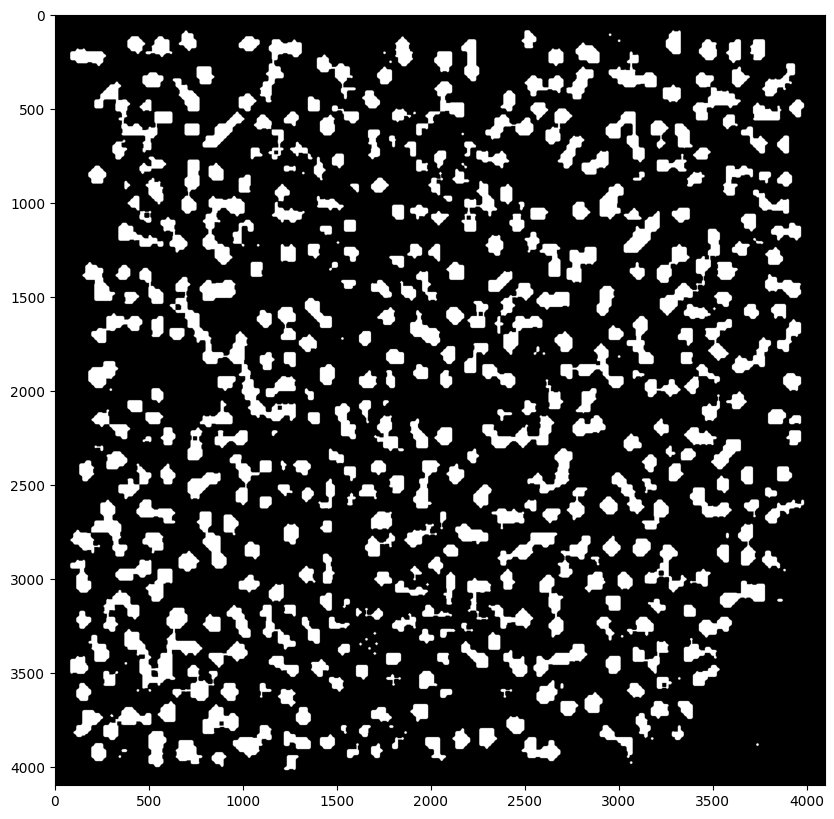

In [5]:
# 去碎片化
import cv2
import numpy as np

def remove_small_fragments(mask):
    # 考虑每个像素周围的 3x3 区域
    # cv2.MORPH_RECT :创建一个矩形结构元素。
    # cv2.MORPH_CROSS：创建一个十字形结构元素。
    # cv2.MORPH_ELLIPSE：创建一个椭圆形结构元素。
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,20))

    # 进行形态学闭运算（膨胀后腐蚀）填充前景物体中的小孔洞
    # 平滑前景物体的边界，同时不改变其面积
    
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # 进行形态学开运算（腐蚀后膨胀），以去除小的碎片
    # 去除前景物体中的小碎片，同时不改变其面积
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask

mask_denoise=remove_small_fragments(mask)
plt.figure(figsize=(10, 10))
plt.imshow(mask_denoise, cmap='gray')
plt.show()

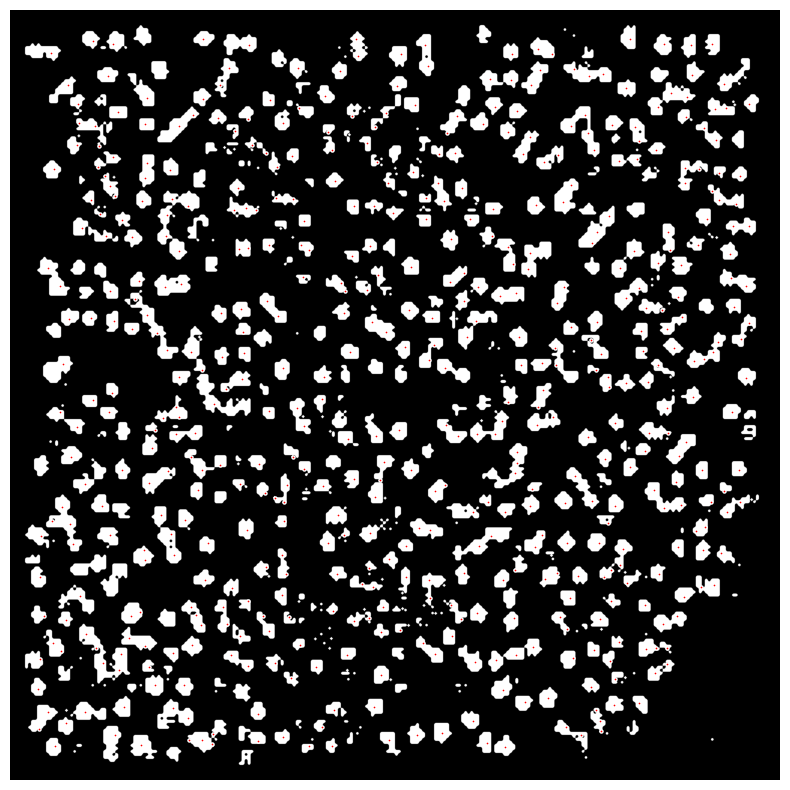

In [3]:
# 除去点位对应的mask
import cv2
import numpy as np
import json
from skimage.measure import find_contours

def extract_and_process_contours(mask_denoise, points_to_remove ,star_points):
  
    # 找到所有轮廓
    contours, _ = cv2.findContours(mask_denoise, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ares=[]
    for contour in contours:
        contour_area = cv2.contourArea(contour)
        ares.append(contour_area)

    # ares.sort()
    # min_area = ares[int(len(ares)*0.2)]
    # 计算 aras 列表的平均值
    # 使用平均值的 0.3 倍作为 min_area
    if ares:  # 确保列表非空，避免除以0错误
        avg_area = sum(ares) / len(ares)
        min_area = avg_area * 0.3
    else:
        min_area = 0
        
    # 创建一个空的掩码来存储结果
    final_mask = np.zeros_like(mask_denoise)

    # 遍历每个轮廓
    for contour in contours:
                # 计算轮廓的面积
        contour_area = cv2.contourArea(contour)

        # 如果面积小于，跳过该轮廓
        if contour_area < min_area:
            continue
        
        flag=False
        # 检查指定的点位是否在当前轮廓内
        for point in points_to_remove:
          # 用于测试一个点是否在多边形轮廓内、外或在边上
            if cv2.pointPolygonTest(contour, tuple(point), False) >= 0:
                point= (int(point[0]), int(point[1]))
                star_points.append(point)
                flag=True
                
        if flag==False:
            cv2.drawContours(final_mask, [contour], -1, (255), thickness=cv2.FILLED)

    return final_mask


star_points=[]
# 处理掩码
final_mask = extract_and_process_contours(mask, restored_points ,star_points)

plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.axis("off")  # 隐藏坐标轴

# 标注点
x_coords = [point[0] for point in star_points]
y_coords = [point[1] for point in star_points]
plt.scatter(x_coords, y_coords, c='red', s=5, edgecolor='white')
plt.show()

# # 展示结果
# plt.figure(figsize=(5, 5))
# plt.imshow(final_mask, cmap='gray')
# plt.axis("off")  # 隐藏坐标轴

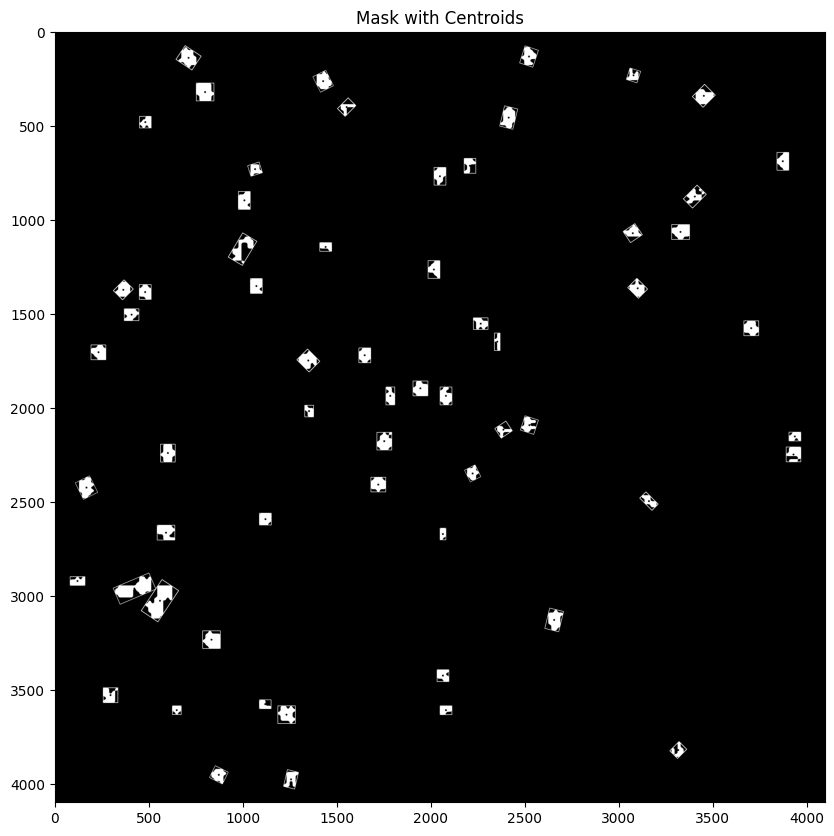

In [5]:
contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 在原始图像上复制一份，以便标记质心
output_mask =np.zeros_like(final_mask)

# ares=[]
# for contour in contours:
    # contour_area = cv2.contourArea(contour)
    # ares.append(contour_area)

# ares.sort()
# min_area = ares[int(len(ares)*0.2)]
# 计算 aras 列表的平均值
# 使用平均值的 0.3 倍作为 min_area
# if ares:  # 确保列表非空，避免除以0错误
#     avg_area = sum(ares) / len(ares)
#     min_area = avg_area * 0.3
# else:
#     min_area = 0

for contour in contours:
        # 计算轮廓的面积
    # contour_area = cv2.contourArea(contour)

    # 如果面积小于，跳过该轮廓
    # if contour_area < min_area:
    #     continue
     # 获取最小外接矩形
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)  # 获取矩形的四个顶点
    box = np.intp(box)  # 将坐标转换为整数
    
    # 获取质心（矩形的中心）
    center = rect[0]

    # 在原mask上标记质心位置
    cv2.drawContours(output_mask, [contour], -1, (255), thickness=cv2.FILLED)
    cv2.drawContours(output_mask, [box], 0, (255), thickness=2)
    cv2.circle(output_mask, (int(center[0]), int(center[1])), 5, (0, 0, 0), -1)  # 用红色圆点标记

# 显示结果
plt.figure(figsize=(10, 10))
plt.imshow(output_mask, cmap='gray')
plt.title('Mask with Centroids')
plt.show()
